In [21]:
import os, glob
import numpy as np
import nibabel as nib
from monai.transforms import NormalizeIntensity
import shutil
from distutils.dir_util import copy_tree

In [32]:
flair_name = "_flair.nii"
t1_name = "_t1.nii"
t1ce_name = "_t1ce.nii"
t2_name = "_t2.nii"
mask_name = "_seg.nii"

In [3]:
dataInputPath = '/mnt/asgard2/data/lingkai/braTS20/BraTS2020_TrainingData/'

In [8]:
dataOutputPath_img = '/mnt/asgard2/data/lingkai/braTS20/slice/image'
dataOutputPath_mask = '/mnt/asgard2/data/lingkai/braTS20/slice/mask'

In [30]:
if not os.path.exists(dataOutputPath_mask):
    os.mkdir(dataOutputPath_mask)
if not os.path.exists(dataOutputPath_img):
    os.mkdir(dataOutputPath_img)

In [46]:
def normalizeImageIntensityRange(imgSlice, leftboound=1, rightbound=99):
    slice_min = np.percentile(imgSlice, leftboound)
    slice_max = np.percentile(imgSlice, rightbound)
    imgSlice = np.clip(imgSlice, slice_min, slice_max)
    normalizeIntensity = NormalizeIntensity(nonzero=True)
    imgSliceNorm = normalizeIntensity(imgSlice)
    return imgSliceNorm

In [47]:
def crop_center(img, cropx=160, cropy=160):
    y, x, _ = img.shape
    startx = x//2 - cropx//2
    starty = y//2 - cropy//2    
    return img[starty:starty+cropy, startx:startx+cropx, :]

In [48]:
# Read image or mask volume
def readImageVolume(imgPath, normalize=False):
    img = nib.load(imgPath).get_fdata()
    if normalize:
        return normalizeImageIntensityRange(img)
    else:
        return img

In [16]:
train_subdir = []
for (dirpath, dirnames, filenames) in os.walk(dataInputPath):
    if len(dirnames):
        train_subdir = dirnames

In [49]:
# Save volume slice to file
def saveSlice(img, fname, path):
    fout = os.path.join(path, f'{fname}.npy')
    np.save(fout, img)
    print(f'[+] Slice saved: {fout}', end='\r')

In [41]:
for subdir in train_subdir:
    path = os.path.join(dataInputPath, subdir)
    flair_path = os.path.join(path, subdir + flair_name)
    t1_path = os.path.join(path, subdir + t1_name)
    t1ce_path = os.path.join(path, subdir + t1ce_name)
    t2_path = os.path.join(path, subdir + t2_name)
    mask_path = os.path.join(path, subdir + mask_name)

    flair = readImageVolume(flair_path, normalize=True)
    t1 = readImageVolume(t1_path, normalize=True)
    t1ce = readImageVolume(t1ce_path, normalize=True)
    t2 = readImageVolume(t2_path, normalize=True)
    mask = readImageVolume(mask_path, normalize=False)

    flair_crop = crop_center(flair)
    t1_crop = crop_center(t1)
    t1ce_crop = crop_center(t1ce)
    t2_crop = crop_center(t2)
    mask_crop = crop_center(mask)

    for n_slice in range(flair_crop.shape[-1]): # take slice on the z-axis
        if np.max(mask_crop[:, :, n_slice]) != 0:
            mask_slice = mask_crop[:, :, n_slice]

            flair_slice = np.expand_dims(flair_crop[:, :, n_slice].astype(float), axis=0)
            t1_slice = np.expand_dims(t1_crop[:, :, n_slice].astype(float), axis=0)
            t1ce_slice = np.expand_dims(t1ce_crop[:, :, n_slice].astype(float), axis=0)
            t2_slice = np.expand_dims(t2_crop[:, :, n_slice].astype(float), axis=0)

            image_slice = np.concatenate((flair_slice, t1_slice, t1ce_slice, t2_slice), axis=0)
            

            saveSlice(image_slice, subdir+f'-slice{str(n_slice).zfill(3)}_z', dataOutputPath_img)
            saveSlice(mask_slice, subdir+f'-slice{str(n_slice).zfill(3)}_z', dataOutputPath_mask)   

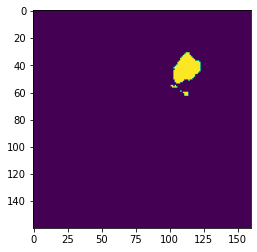

In [49]:
import matplotlib.pyplot as plt
x = np.load('/mnt/asgard2/data/lingkai/braTS20/slice/LabelTs/BraTS20_Training_050-slice099_z.npy')
plt.imshow(x[3, :, :], cmap='gray')

## Seperate Training and Test Dataset

Training samples: 158 ~ 259, 271 ~ 335 (BraTS17, BraTS19 TCIA), Test samples: 1 ~ 129 (BraTS17 CBICA)

In [6]:
trainOutputPath_img = '/mnt/asgard2/data/lingkai/braTS20/slice/ImageTr/'
testOutputPath_img = '/mnt/asgard2/data/lingkai/braTS20/slice/ImageTs/'

trainOutputPath_label = '/mnt/asgard2/data/lingkai/braTS20/slice/LabelTr/'
testOutputPath_label = '/mnt/asgard2/data/lingkai/braTS20/slice/LabelTs/'

In [4]:
BraTS17_CBICA_HGG = (1, 89)
BraTS19_CBICA_HGG = (89, 130)
BraTS13_HGG = (130, 150)
BraTS19_TMC_HGG = (150, 158)
BraTS17_TCIA_HGG = (158, 260)
BraTS17_LGG = (260, 270)
BraTS19_TMC_LGG = (270, 271)
BraTS17_TCIA_LGG = (271, 336)
BraTS20_HGG = (336, 370)

In [17]:
BraTS17_TCIA_HGG_ImagePath = '/mnt/asgard2/data/lingkai/braTS20/slice/BraTS17_TCIA_HGG/image'
start, end = BraTS17_TCIA_HGG
for file in os.listdir(dataOutputPath_img):
    for i in range(start, end):
        if f'Training_{str(i).zfill(3)}' in file:
            sourcePath = os.path.join(dataOutputPath_img, file)
            shutil.copy(sourcePath, BraTS17_TCIA_HGG_ImagePath)

In [18]:
BraTS17_TCIA_HGG_LabelPath = '/mnt/asgard2/data/lingkai/braTS20/slice/BraTS17_TCIA_HGG/label'
start, end = BraTS17_TCIA_HGG
for file in os.listdir(dataOutputPath_mask):
    for i in range(start, end):
        if f'Training_{str(i).zfill(3)}' in file:
            sourcePath = os.path.join(dataOutputPath_mask, file)
            shutil.copy(sourcePath, BraTS17_TCIA_HGG_LabelPath)

In [19]:
BraTS17_CBICA_HGG_ImagePath = '/mnt/asgard2/data/lingkai/braTS20/slice/BraTS17_CBICA_HGG/image'
start, end = BraTS17_CBICA_HGG
for file in os.listdir(dataOutputPath_img):
    for i in range(start, end):
        if f'Training_{str(i).zfill(3)}' in file:
            sourcePath = os.path.join(dataOutputPath_img, file)
            shutil.copy(sourcePath, BraTS17_CBICA_HGG_ImagePath)

In [20]:
BraTS17_CBICA_HGG_LabelPath = '/mnt/asgard2/data/lingkai/braTS20/slice/BraTS17_CBICA_HGG/label'
start, end = BraTS17_CBICA_HGG
for file in os.listdir(dataOutputPath_mask):
    for i in range(start, end):
        if f'Training_{str(i).zfill(3)}' in file:
            sourcePath = os.path.join(dataOutputPath_mask, file)
            shutil.copy(sourcePath, BraTS17_CBICA_HGG_LabelPath)

In [23]:
BraTS17_TCIA_HGG_Path  = '/mnt/asgard2/data/lingkai/braTS20/BraTS17_TCIA_HGG/'
Traindataset = '/mnt/asgard2/data/lingkai/braTS20/BraTS2020_TrainingData/'
start, end = BraTS17_TCIA_HGG
for dir in os.listdir(Traindataset):
    for i in range(start, end):
        if f'Training_{str(i).zfill(3)}' in dir:
            sourcePath = os.path.join(Traindataset, dir)
            targetPath = os.path.join(BraTS17_CBICA_HGG_Path, f'BraTS20_Training_{str(i).zfill(3)}')
            if not os.path.exists(targetPath):
                os.mkdir(targetPath)
            copy_tree(sourcePath, targetPath)


BraTS2021 Challenge Dataset

In [23]:
import os, glob
import numpy as np
import nibabel as nib
from monai.transforms import NormalizeIntensity

In [52]:
flair_name = "_flair.nii.gz"
t1_name = "_t1.nii.gz"
t1ce_name = "_t1ce.nii.gz"
t2_name = "_t2.nii.gz"
mask_name = "_seg.nii.gz"

In [41]:
dataInputPath = '/mnt/asgard2/data/lingkai/braTS21/train_data/'

In [42]:
dataOutputPath_img = '/mnt/asgard2/data/lingkai/braTS21/slice/images'
dataOutputPath_mask = '/mnt/asgard2/data/lingkai/braTS21/slice/mask'

In [43]:
if not os.path.exists(dataOutputPath_mask):
    os.mkdir(dataOutputPath_mask)
if not os.path.exists(dataOutputPath_img):
    os.mkdir(dataOutputPath_img)

In [44]:
train_subdir = []
for (dirpath, dirnames, filenames) in os.walk(dataInputPath):
    if len(dirnames):
        train_subdir = dirnames

In [53]:
for subdir in train_subdir:
    path = os.path.join(dataInputPath, subdir)
    flair_path = os.path.join(path, subdir + flair_name)
    t1_path = os.path.join(path, subdir + t1_name)
    t1ce_path = os.path.join(path, subdir + t1ce_name)
    t2_path = os.path.join(path, subdir + t2_name)
    mask_path = os.path.join(path, subdir + mask_name)

    flair = readImageVolume(flair_path, normalize=True)
    t1 = readImageVolume(t1_path, normalize=True)
    t1ce = readImageVolume(t1ce_path, normalize=True)
    t2 = readImageVolume(t2_path, normalize=True)
    mask = readImageVolume(mask_path, normalize=False)

    flair_crop = crop_center(flair)
    t1_crop = crop_center(t1)
    t1ce_crop = crop_center(t1ce)
    t2_crop = crop_center(t2)
    mask_crop = crop_center(mask)

    for n_slice in range(flair_crop.shape[-1]): # take slice on the z-axis
        if np.max(mask_crop[:, :, n_slice]) != 0:
            mask_slice = mask_crop[:, :, n_slice]

            flair_slice = np.expand_dims(flair_crop[:, :, n_slice].astype(float), axis=0)
            t1_slice = np.expand_dims(t1_crop[:, :, n_slice].astype(float), axis=0)
            t1ce_slice = np.expand_dims(t1ce_crop[:, :, n_slice].astype(float), axis=0)
            t2_slice = np.expand_dims(t2_crop[:, :, n_slice].astype(float), axis=0)

            image_slice = np.concatenate((flair_slice, t1_slice, t1ce_slice, t2_slice), axis=0)
            

            saveSlice(image_slice, subdir+f'-slice{str(n_slice).zfill(3)}_z', dataOutputPath_img)
            saveSlice(mask_slice, subdir+f'-slice{str(n_slice).zfill(3)}_z', dataOutputPath_mask)  